In [22]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score

In [23]:
data = pd.read_csv('../../dataset/deceptive-opinion.csv/deceptive-opinion.csv')
# Keeping only the neccessary columns
data = data[['text','polarity','deceptive']]
data['text'] = data['text'].map(lambda text: text if type(text)!=str else text.lower())

In [24]:
# Splitting the dataset into train and test set
train, test = train_test_split(data,test_size = 0.2)
# Removing neutral sentiments
train = train[train.polarity != "Neutral"]
train.loc[train.polarity == 'negative', 'polarity'] = 0
train.loc[train.polarity == 'positive', 'polarity'] = 1
test.loc[test.polarity == 'negative', 'polarity'] = 0
test.loc[test.polarity == 'positive', 'polarity'] = 1

C:\Users\varun\Anaconda2\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\varun\Anaconda2\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [25]:
X_train = train['text'].values
X_test = test['text'].values
y_train = train['polarity'].astype(int)
y_test = test['polarity'].astype(int)

In [26]:
def tokenize(text): 
    tknzr = TweetTokenizer()
    return tknzr.tokenize(text)

def stem(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

en_stopwords = set(stopwords.words("english")) 

vectorizer = CountVectorizer(
    analyzer = 'word',
    tokenizer = tokenize,
    lowercase = True,
    ngram_range=(1, 1),
    stop_words = en_stopwords)

In [27]:
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [28]:
np.random.seed(1)

pipeline_svm = make_pipeline(vectorizer, 
                            SVC(probability=True, kernel="linear", class_weight="balanced"))

grid_svm = GridSearchCV(pipeline_svm,
                    param_grid = {'svc__C': [0.01, 0.1, 1]}, 
                    cv = kfolds,
                    scoring="roc_auc",
                    verbose=1,   
                    n_jobs=1) 

grid_svm.fit(X_train, y_train)


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   47.6s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer='word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_word...',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'svc__C': [0.01, 0.1, 1]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='roc_auc', verbose=1)

In [29]:
grid_svm.score(X_test, y_test)

0.9789833438089253

In [30]:
grid_svm.best_params_

{'svc__C': 0.01}

In [31]:
grid_svm.best_score_

0.9736636669124981

In [32]:
def report_results(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    pred = model.predict(X)        

    auc = roc_auc_score(y, pred_proba)
    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred)
    prec = precision_score(y, pred)
    rec = recall_score(y, pred)
    result = {'auc': auc, 'f1': f1, 'acc': acc, 'precision': prec, 'recall': rec}
    return result

In [33]:
report_results(grid_svm.best_estimator_, X_test, y_test)

{'acc': 0.91875,
 'auc': 0.9789833438089253,
 'f1': 0.9265536723163842,
 'precision': 0.9010989010989011,
 'recall': 0.9534883720930233}

In [15]:
def get_roc_curve(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, pred_proba)
    return fpr, tpr

In [16]:
roc_svm = get_roc_curve(grid_svm.best_estimator_, X_test, y_test)

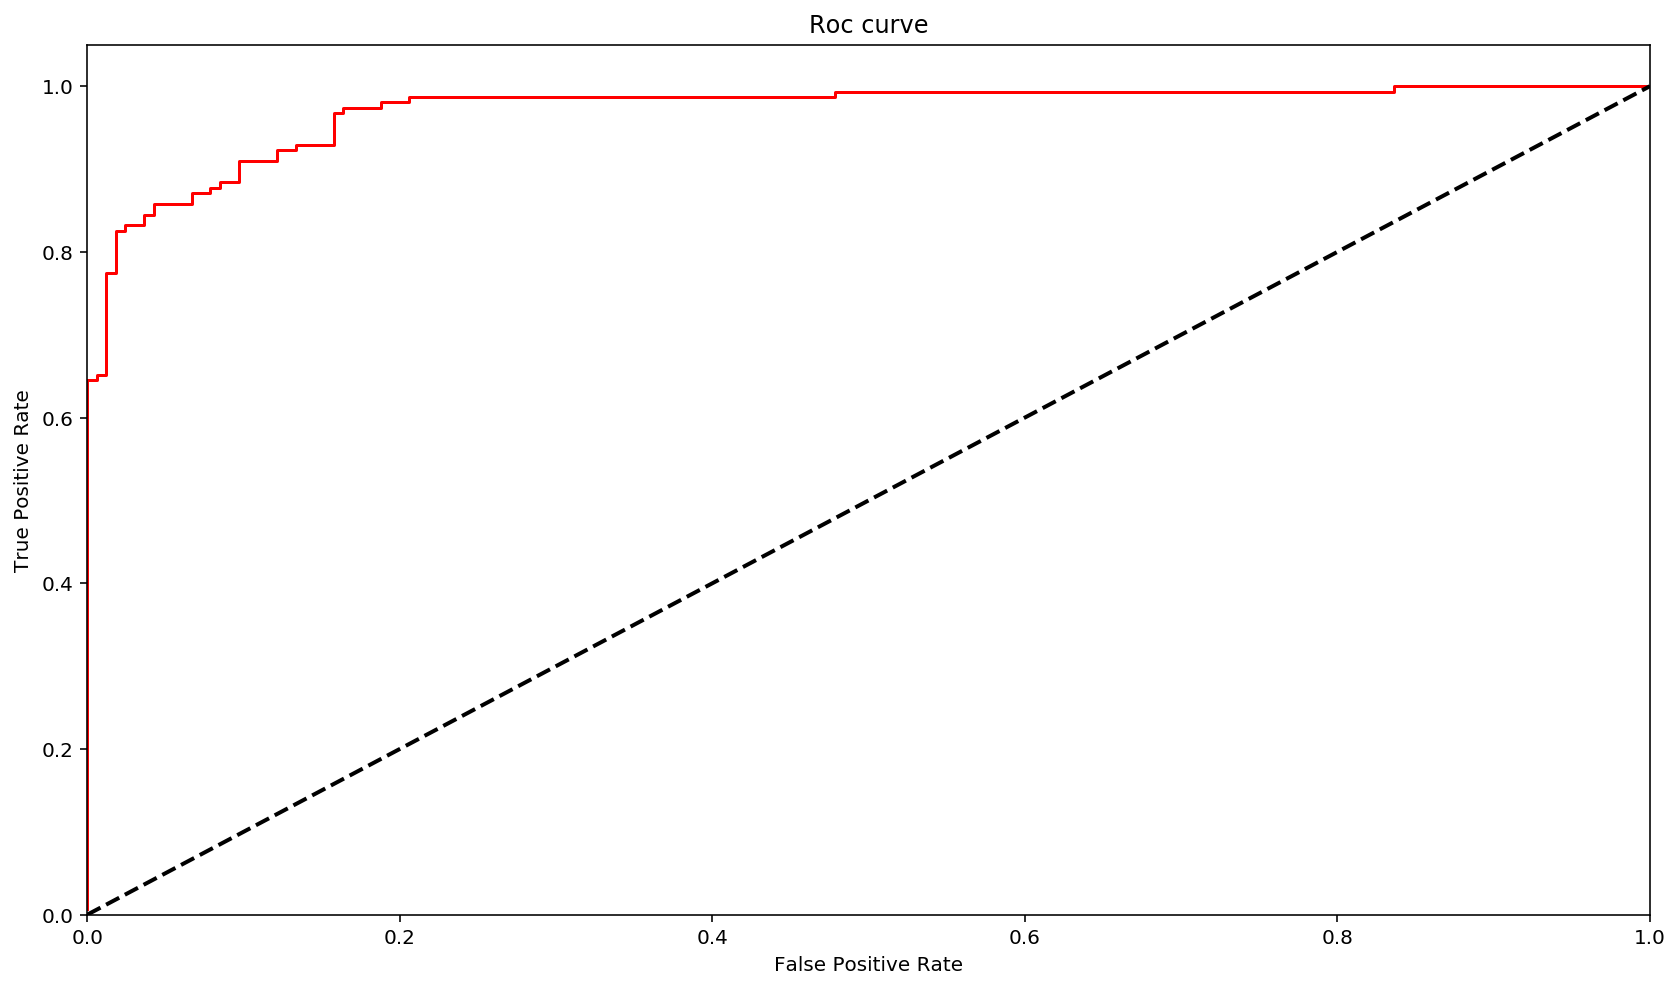

In [17]:
fpr, tpr = roc_svm
plt.figure(figsize=(14,8))
plt.plot(fpr, tpr, color="red")
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc curve')
plt.show()

In [19]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = \
    learning_curve(grid_svm.best_estimator_, X_train, y_train, cv=5, n_jobs=1, 
                   scoring="roc_auc", train_sizes=np.linspace(.1, 1.0, 10), random_state=1)

In [20]:
def plot_learning_curve(X, y, train_sizes, train_scores, test_scores, title='', ylim=None, figsize=(14,8)):

    plt.figure(figsize=figsize)
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="lower right")
    return plt

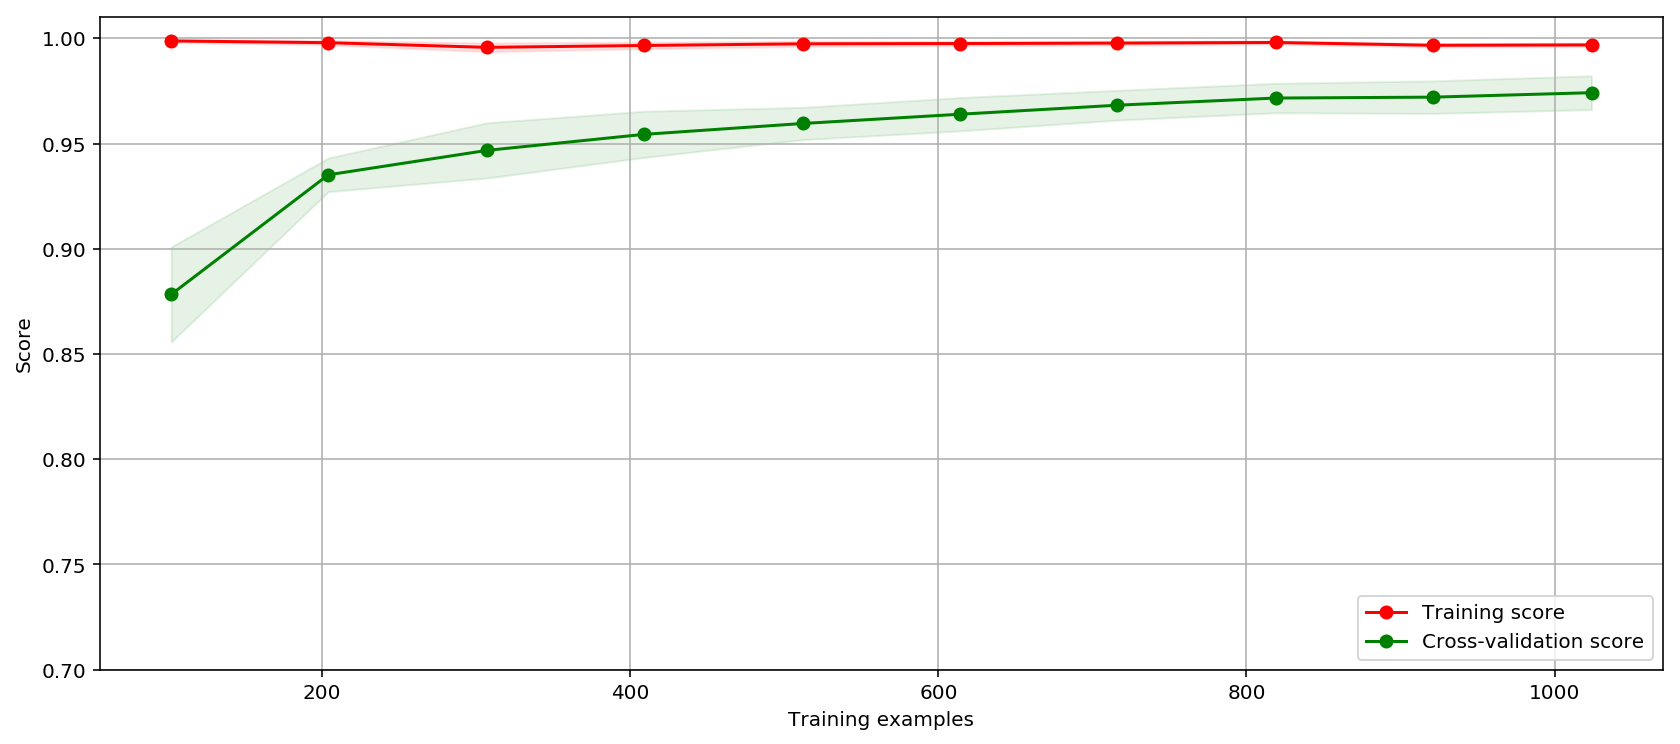

In [21]:
plot_learning_curve(X_train, y_train, train_sizes, 
                    train_scores, test_scores, ylim=(0.7, 1.01), figsize=(14,6))
plt.show()